In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]!='Unk']

In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 39583 cells


#### Data preparation

In [9]:
sf.data_preparation(obj)

#### Removing general genes

In [10]:
s1 = time.time()

In [11]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [12]:
obj = sf.remove_housekeepingenes(obj, path="../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [13]:
obj = sf.remove_features_pct(obj, group_by="Cell broad annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [14]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell broad annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [15]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.900475984422328


In [16]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### ensemble_learning

In [17]:
s2 = time.time()

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

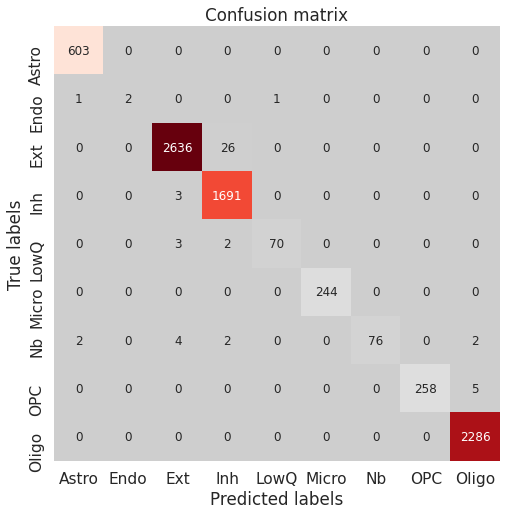

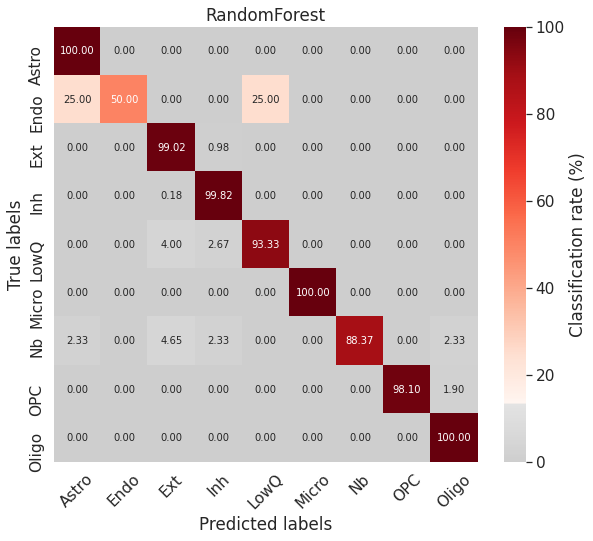

Accuracy: 0.9935581659719591: Misclassification: 0.0064418340280408826
              precision    recall  f1-score   support

       Astro       1.00      1.00      1.00       603
        Endo       1.00      0.50      0.67         4
         Ext       1.00      0.99      0.99      2662
         Inh       0.98      1.00      0.99      1694
        LowQ       0.99      0.93      0.96        75
       Micro       1.00      1.00      1.00       244
          Nb       1.00      0.88      0.94        86
         OPC       1.00      0.98      0.99       263
       Oligo       1.00      1.00      1.00      2286

    accuracy                           0.99      7917
   macro avg       1.00      0.92      0.95      7917
weighted avg       0.99      0.99      0.99      7917



In [18]:
clf = sf.ensemble_learning(obj, group_by="Cell broad annotation", classifier="RandomForest", balance=True, verbose=True)

#### gini_importance

In [19]:
selectedGenes, selectedGenes_dict = sf.gini_importance(obj, clf, group_by="Cell broad annotation", verbose=True, restrict_top=("local", 20))

In [20]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

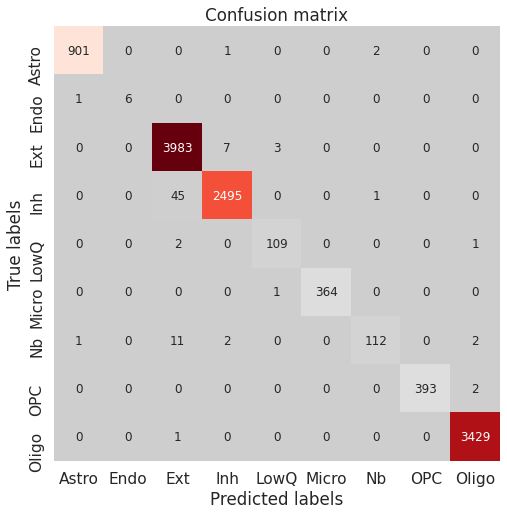

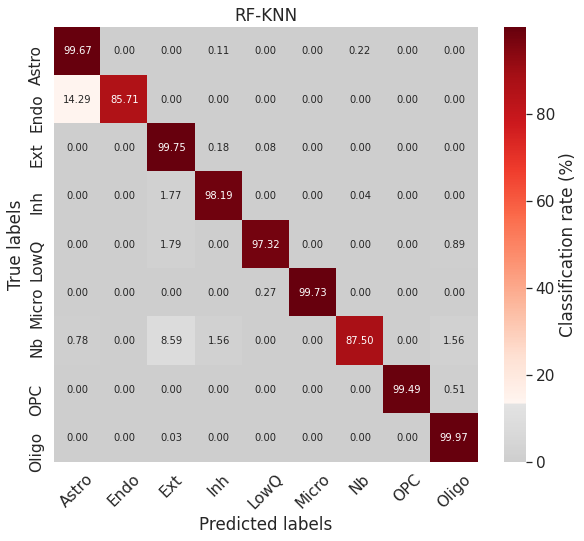

Accuracy: 0.9930105263157895: Misclassification: 0.006989473684210545
              precision    recall  f1-score   support

       Astro       1.00      1.00      1.00       904
        Endo       1.00      0.86      0.92         7
         Ext       0.99      1.00      0.99      3993
         Inh       1.00      0.98      0.99      2541
        LowQ       0.96      0.97      0.97       112
       Micro       1.00      1.00      1.00       365
          Nb       0.97      0.88      0.92       128
         OPC       1.00      0.99      1.00       395
       Oligo       1.00      1.00      1.00      3430

    accuracy                           0.99     11875
   macro avg       0.99      0.96      0.98     11875
weighted avg       0.99      0.99      0.99     11875



In [21]:
sf.run_classifiers(obj, group_by="Cell broad annotation", genes=selectedGenes, classifier="KNN", balance=True, title="RF-KNN")

#### Sorting genes per cluster

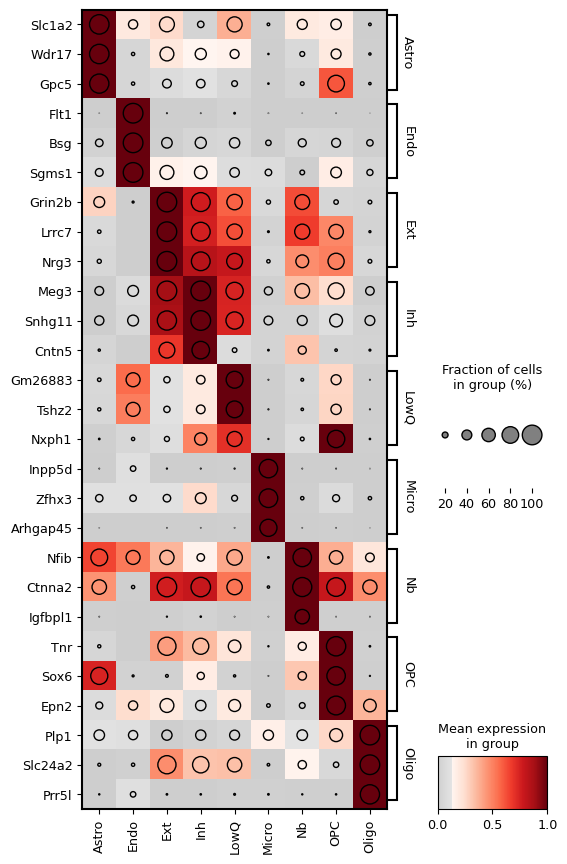

In [22]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell broad annotation", top=3, figsize=(6,10))

In [23]:
e1 = time.time()

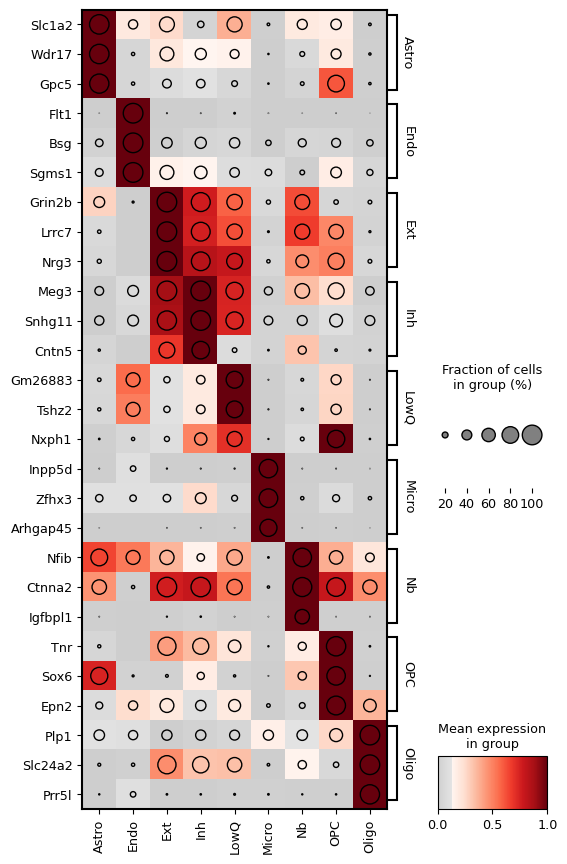

In [24]:
axs.savefig("Figures/RF_top5_perGroup.pdf")

# Elapsed time

In [25]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

4162 genes across 39583 cells


In [26]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  568.3836297988892


In [27]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  114.15514469146729
